# Assignment 3 - AI2

__Student's Credentials__: Vissarion Moutafis - sdi1800119

In this assignment we will try to create an effective ML pipeline that will get a raw sentence and will predict whether the sentence is pro-vaccine or anti-vaccine or neutral. The training corpus comes from twitter, as well as the evaluation dataset.


## Imports and Google Drive connect

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn
import re

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, accuracy_score, confusion_matrix, recall_score, log_loss
from sklearn.decomposition import PCA
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, classification_report

import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

seaborn.set_style("ticks")
nltk.download("stopwords")
nltk.download("wordnet")

import torch
import torch.nn as nn
import torchtext
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

!pip install tqdm
from tqdm import tqdm, trange

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preprocessing and GLoVe Embeddings

- Clean the tweets
- Prepare a nn.Dataset class
- Construct a tweet embeddings layer
- Build a word id mapping 
- Build the train vocabulary
- Create a trained Weights matrix and make it the default Weight matrix of the embeddings layer
- Ready to use embeddings with dataloader struct 

In [4]:
# CHANGE THIS ONLY
dir_path = '/content/drive/MyDrive/Collab-Datasets/Vaccine Sentiment Dataset/'
# dir_path = '../input/vaccine-sentiment-analysis/'


In [5]:
train_dt_path = dir_path + "vs_train.csv"
test_dt_path = dir_path + "vs_dev.csv"

LABELS = ['neutral', 'anti-vax', 'pro-vax']

In [6]:
train_df_raw = pd.read_csv(train_dt_path, index_col=0)
test_df_raw = pd.read_csv(test_dt_path, index_col=0)

train_df_raw.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [7]:
# get test/test X and y
X_train_raw, y_train = train_df_raw["tweet"].to_numpy().reshape((-1,1)), train_df_raw["label"].to_numpy().reshape((-1))
X_test_raw, y_test = test_df_raw["tweet"].to_numpy().reshape((-1,1)), test_df_raw["label"].to_numpy().reshape((-1))

In [8]:
sw = set([re.sub(r'[^\w\s]', '', w) for w in stopwords.words("english")])
lemmatizer = WordNetLemmatizer()

In [20]:
def clean_tweet(tweet, remove_whole_http=False):
  temp = str(tweet).lower().strip(' ').strip('\t') # all to lowercase
  if remove_whole_http:
    temp = re.sub("http\S+", '', temp) # remove the whole http
  else:
    temp = re.sub(r'http\S*://', '', temp) # keep only the part after http(s), might be interesting 
    temp = re.sub(r'/', ' ', temp) # separate domain from link ending
    
  temp = re.sub('("@\w+.*?)',"", temp)
  temp = re.sub(r'([^\w\s])+', '', temp) # remove punctuation

  temp = " ".join([lemmatizer.lemmatize(w) for w in temp.split() if w not in sw]) #lemmatize and remove stopwords
  temp = re.sub(r'\s+', ' ', temp)

  return temp 

def clean_tweets(X, remove_whole_http=False):
  return np.apply_along_axis(clean_tweet, 1, X, remove_whole_http)

In [21]:
train_tweets, test_tweets = clean_tweets(X_train_raw), clean_tweets(X_test_raw)

In [22]:
avg_len = sum([len(s.split()) for s in train_tweets]) / len(train_tweets)
print(f'Average Sentence length: {avg_len}')

Average Sentence length: 10.53761892839259


### ClassifierDataset Class

We overload the torch Dataset class in order to create a data loader and use batches during training

In [24]:
class ClassifierDataset(torch.utils.data.Dataset):
  def __init__(self, X_data, y_data):
    self.X_data = X_data
    self.y_data = y_data
        
  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]
        
  def __len__ (self):
    return len(self.X_data)

### GLoVe Embeddings Layer

The Following embeddings layer will be able to take a whole training set of tweets and transform them to the respective glove embedding sequences, according to a predetermined sequence max size. At the end of smaller sentences we will put a special tag \<end\> and after that some \<pad\> tags. 

**NOTE**: If tweets are smaller than the max sentence length given by the user, we will pad the sequence with a special vector (zeros).

In [26]:
class TweetEmbeddings(torch.nn.Embedding):
  def __init__(self, id_map, max_sentence_length, num_embeddings, embeddings_dim, padding_idx=0):
    super(TweetEmbeddings, self).__init__(num_embeddings, embeddings_dim, padding_idx=padding_idx)
    self.id_map = id_map
    self.max_sentence_len = max_sentence_length
    self.text_len = []

  def tweet2ids(self, tweet):
    ids = []
    
    for w in tweet.split():
      if w in self.id_map:
        ids.append(self.id_map[w])

    ids.append(self.id_map['<end>'])
    self.text_len.append(min(self.max_sentence_len, len(tweet.split())))

    # add padding, if necessary
    for i in range(len(ids), self.max_sentence_len):
      ids.append(self.id_map['<pad>'])
    
    # in case the tweet has more series than necessary we will cut from the end (done easily with list slicing)
    ids = ids[:self.max_sentence_len] 

    return ids

  def __call__(self, tweets):
    self.text_len = []
    return torch.stack([
                        super(TweetEmbeddings, self).__call__(torch.LongTensor(self.tweet2ids(tweet))) for tweet in tweets
    ]), self.text_len

In [27]:
# set up dir of glove embeddings or uncomment the following 2 lines to download
dir_glove = '/content/drive/MyDrive/Collab-Datasets/'
# dir_glove = '../input/glove6b/'

# !wget nlp.stanford.edu/data/wordvecs/glove.6B.zip
# !unzip glove.6B.zip
# !ls -l

In [28]:
def parse_line(line) :
  line_split = line.split()
  word = clean_tweet(line_split[0])
  vec = np.asarray(line_split[1:], dtype=np.float64)
  return word, vec

# create vocabulary of pro/neutral/anti vax
def create_vocab(tweets, labels) :
  v = set()
  for tweet, label in zip(tweets, labels):
    for tok in tweet.split():
      v.add(tok)      
  return v

Parse the Glove embeddings and and create vocab for the embeddings layer.

In [29]:
N_EMBEDDINGS = 100
MAX_EMB_SERIES_LEN = 15
# create a word_idx to embedding dict and a tokenizer dict. Add <pad> and <unknown> as utility-special embeddings
word_emb = {'<pad>':np.zeros((N_EMBEDDINGS,)), '<end>':np.random.normal(scale=0.6, size=(N_EMBEDDINGS,))}
word2idx = {'<pad>':0, '<end>':1}
idx = 2

with open(dir_glove + f"glove.6B.{N_EMBEDDINGS}d.txt") as embeddings_file:
  for line in embeddings_file.readlines():
    word, vec = parse_line(line)
    word_emb[word] = vec

To create the embedding layer we must provide it with a frozen weights matrix, $W$, that will be consisted of the pretrained embeddings we loaded.

In [30]:
# create weight matrix for word embeddings
def create_W(target_vocab, word2emb, n_features):
  global idx

  # concat all words from all vocabularies and init the weight matrix
  W = np.zeros((len(target_vocab)+2, n_features))
  W[1] = word_emb['<end>']
  idx=2
#  parse all the words and create the respective embedding weights
  for i, w in enumerate(target_vocab):
    #  add the word in the indexing table
    word2idx[w] = idx 
    idx += 1

    # consider the importance of the embedding
    try:
      W[i+2] = word2emb[w]
    except KeyError:
      W[i+2] = np.random.normal(scale=0.6, size=(n_features,))
      word2emb[w] = W[i+2]
  return W


In [31]:
train_tweets_vocab = create_vocab(train_tweets, y_train)

In [32]:
train_weights = create_W(train_tweets_vocab, word_emb, N_EMBEDDINGS)

In [148]:
num_embeddings, embeddings_dim = train_weights.shape
emb_layer = TweetEmbeddings(word2idx, 25, num_embeddings, embeddings_dim, padding_idx=0)
emb_layer.load_state_dict({'weight' : torch.from_numpy(train_weights).float()})
emb_layer.weight.requires_grad = False

### Train-Test loader preparation

We use the embeddings layer to transform the tweets and create data loaders that will distribute the batches to the models.

In [149]:
X_train, train_tweet_lens = emb_layer(train_tweets)
# packed_X_train = pack_padded_sequence(X_train, train_tweet_lens, batch_first=True, enforce_sorted=False)

X_test, test_tweet_lens = emb_layer(test_tweets)
# packed_X_test = pack_padded_sequence(X_test, test_tweet_lens, batch_first=True, enforce_sorted=False)

D_train = ClassifierDataset(X_train.to(device), torch.LongTensor(y_train).to(device))
train_loader = torch.utils.data.DataLoader(D_train, batch_size=2048) 

D_test = ClassifierDataset(X_test.to(device), torch.LongTensor(y_test).to(device))
test_loader = torch.utils.data.DataLoader(D_test, batch_size=len(X_test))

### Embeddings RNN Model Wrapper

Create a torch Module, that will hold our model settings. 

The user will be able to provide the model with different layers of different hidden size, dropout between mutliple layers, cell type, activation layers and skip layers architecture among different layers between RNN layers of the same hidden size.

The user will also provide the attention layer, making sure that he sets the appropriate size in the constructor.

This class also provides us with its own train step that updates history and returns test and train loss.

In [150]:
class EmbeddingsRNN(nn.Module):
    CLIPVAL = 5.0
    """
    Basic Embeddings prediction model. Consisted of rnn_layers, an embeddings layer, dropout layers, activation and 2 densely connected linear layers for final processing.
    The user can add attention layer after the last RNN, so he should set the input dimension properly.
    """
    def __init__(self, device, emb_layer, input_dim, rnn_layers_settings, cell_type='LSTM', skip_layers=False, skip_activation=nn.ReLU, attention_layer=None, activation=torch.nn.ReLU, dropout_rate=0.4, n_classes=3, verbose=False):
      cell = {'LSTM' : nn.LSTM, 'GRU' : nn.GRU}
      super(EmbeddingsRNN, self).__init__()
      self.n_classes = n_classes
      self.device = device
      self.emb_layer = emb_layer
      self.rnn_layers_settings = rnn_layers_settings
      self.verbose = verbose
      self.cell_type = cell_type
      self.skip_layers = skip_layers
      if skip_layers:
        self.skip_activation = skip_activation()

      # output logits layer
      self.fc_out = nn.utils.weight_norm(nn.Linear(2*rnn_layers[-1]['hidden_size'], self.n_classes))      
      self.drop = nn.Dropout(dropout_rate)
      self.attention_layer=attention_layer
      self.rnn_layers = torch.nn.ModuleList()

      in_dim = input_dim
      for settings in rnn_layers_settings:
        self.rnn_layers.append(
            cell[cell_type](
                in_dim,
                hidden_size=settings['hidden_size'],
                num_layers=settings['num_layers'] if 'num_layers' in settings else 1,
                dropout = settings['dropout'] if 'dropout' in settings else 0.0,
                bidirectional=True,
                batch_first=True
            
            )
        )
        in_dim = settings['hidden_size'] * 2 # it's bidirectional RNNs

      self.hidden = []

      if verbose:
        print(self)

    """
    Call method of the model that will pass the input embeddings sequences for each sentece, with shape [batch size, sequence size, embeddings size]
    We will pass the instances through all rnns, skip layers will be added if default mode is changed by caller, hidden states 
    are dealt with internally. Finally we will pass the final hidden state at a Linear layer to get prediction vectors, after a dropout layer.
    If the user provides us with a attention layer defined lower in the notebook, we will pass the last hidden layer and the final rrn sequences through it to 
    set up a concatenated state of context and final hidden state. 
    """
    def forward(self, X):
      x = X
        
      for i,rnn in enumerate(self.rnn_layers):
        # before pass hidden in the rnn make sure to cutoff the rest of gradient graph 
        if self.cell_type == "GRU":
          self.hidden[i] = self.hidden[i].detach()
        else:
          self.hidden[i] = tuple(each.detach() for each in self.hidden[i])

        # pass through rnn
        out, hidden_i = rnn(x, self.hidden[i]) 
        # skip layers if tuned
        if self.skip_layers and i > 0 and i < len(self.rnn_layers)-1:
          try:
            out = self.skip_activation(out) + x
          except: 
            pass
        x = out

      h_n = x[:, -1, :]      
      
      # add attention
      if self.attention_layer is not None:
        h_n, attention_weights = self.attention_layer(x, h_n)
      
      x = x[:, -1, :]
      x = self.drop(x)
      x_out = self.fc_out(x)
      return x_out

    """
    Method that will init hidden layer at the beginning of each step. Determined by cell type, given in the constructor.
    """
    def init_hidden(self, batch_size):
      self.hidden = []
      for settings in self.rnn_layers_settings:
        hidden_size = settings['hidden_size']
        num_layers = settings['num_layers'] if 'num_layers' in settings else 1
        if self.cell_type == "LSTM":
          self.hidden.append(
              (torch.autograd.Variable(torch.zeros(num_layers*2, batch_size, hidden_size)).to(self.device), 
              torch.autograd.Variable(torch.zeros(num_layers*2, batch_size, hidden_size)).to(self.device))
          )
        else:
          self.hidden.append(
              torch.autograd.Variable(torch.zeros(num_layers*2, batch_size, hidden_size)).to(self.device)
          )

    """
    Training step that passes the train batches, 
    estimates loss (train and test), applies optimizer step and updates history if provided.
    The optimizer and criterion, must be initialized outside of this method.
    """
    def training_step(self, optimizer, criterion, epoch_i, train_loader, eval_loader, history=None):

      # 1 step of backprop with train/test error estimation
      total_loss = 0
      self.init_hidden(train_loader.batch_size)
      
      for _X, _y in train_loader:
        # detach the hidden state so that we consider only the last gradient in backprop
      
        # make sure that we iterate over batch_size batches
        if len(_X) != train_loader.batch_size:
          continue 

        X, y = _X.to(self.device), _y.to(self.device)
        # set the gradients to zero for new estimation
        optimizer.zero_grad() 
        # forward pass
        y_pred = self.forward(X)
        # compute loss 
        loss = criterion(y_pred, y)
        total_loss += loss.item()

        # backpropagate error
        loss.backward()
        # apply gradient clipping adjust model's parameters
        torch.nn.utils.clip_grad_norm_(self.parameters(), self.CLIPVAL)
        optimizer.step()

      train_loss = total_loss/len(train_loader)
      total_loss = 0

      with torch.no_grad():
        self.init_hidden(test_loader.batch_size)
        for _X,_y in eval_loader: 
          # make sure that we iterate over batch_size batches
          if len(_X) != eval_loader.batch_size:
            continue 
          X, y = _X.to(self.device), _y.to(self.device)
          y_pred = self.forward(X)
          loss = criterion(y_pred, y)
          total_loss += loss.item()

      test_loss = total_loss/len(eval_loader)

      # if the user provides with a history dict the training step will save the current epoch's train-test loss
      if history is not None: 
        history['train'].append(train_loss)
        history['test'].append(test_loss)

      if self.verbose:
        print('Epoch {}: train loss: {}, test_loss: {}'.format(epoch_i, train_loss, test_loss))    # Backward pass
      
      return train_loss, test_loss

In [151]:
"""
Use this function to train you models with adam optimizer and cross entropy loss score.
"""
def train_model(history, model, train_loader, test_loader, epochs, _lr, ):
  # set to training mode
  model.train()
  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = _lr)

  pbar = tqdm(range(epochs))
  for epoch in pbar:
    train_loss, test_loss = model.training_step(optimizer, criterion, epoch, train_loader, test_loader, history)
    pbar.set_description('Epoch {}: train loss: {}, test_loss: {}'.format(epoch, train_loss, test_loss), refresh=True)

### Model 1

Classic RNN of 2 layer LSTM

In [152]:
rnn_layers = [
              {'hidden_size':50, 'num_layers':2,  'dropout':0.5},
            ]

model1 = EmbeddingsRNN(device,
                       emb_layer,
                       N_EMBEDDINGS,
                       rnn_layers,
                       cell_type='LSTM',
                       dropout_rate=0.3,
                       activation=nn.ReLU)
model1 = model1.to(device)

history1 = {'train':[], 'test':[]}

In [153]:
train_model(history1, model1, train_loader, test_loader, 25, 0.0025)

Epoch 24: train loss: 0.5501849204301834, test_loss: 0.7669605612754822: 100%|██████████| 25/25 [00:14<00:00,  1.74it/s]


### Model 2
Same with GRU RNN-cells

In [154]:
rnn_layers = [
              {'hidden_size':50, 'num_layers':2, 'dropout':0.4},
            ]

model2 = EmbeddingsRNN(device,
                       emb_layer,
                       N_EMBEDDINGS,
                       rnn_layers,
                       cell_type='GRU',
                       dropout_rate=0.2)
model2 = model2.to(device)

history2 = {'train':[], 'test':[]}

In [155]:
train_model(history2, model2, train_loader, test_loader, 25, 0.0015)

Epoch 24: train loss: 0.5880588069558144, test_loss: 0.7262495756149292: 100%|██████████| 25/25 [00:12<00:00,  1.98it/s]


## Skip Connection 
Adding Skip Connections in the RNN structure, by turning on the appropriate model flag. The skip connection will be appplied after the first group of RNN layers provided in the rnn layers settings.

### Model 3
2 group of layers for GRU model.

In [156]:
rnn_layers = [
              {'hidden_size':50, 'num_layers':2, 'dropout':0.4 },
              {'hidden_size':50, 'num_layers':1 },
              {'hidden_size':50, 'num_layers':1 }
              ]
model3 = EmbeddingsRNN(device,
                       emb_layer,
                       N_EMBEDDINGS,
                       rnn_layers,
                       cell_type='GRU',
                       dropout_rate=0.4,
                       skip_layers=True)
model3 = model3.to(device)
history3 = {'train':[], 'test':[]}

In [157]:
train_model(history3, model3, train_loader, test_loader, 25, 0.0015)

Epoch 24: train loss: 0.5257963538169861, test_loss: 0.7382799983024597: 100%|██████████| 25/25 [00:21<00:00,  1.17it/s]


## Adding attention

We consulted the courses lectures' slides and [this](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) link to implement attention. 

To apply attention we will:
- Train a Linear layer to get attention weights
- Pass the weights $e_i$ through softmax function
- Multiply each hidden vector with its respective attention weight
- Add all the vector to acquire context 
- Concat the final hidden layer with Context in order to get the attention'd vector

In [158]:
import torch.nn.functional as F
class AttentionBlock(nn.Module):
  def __init__(self, hidden_size):
    super(AttentionBlock, self).__init__()
    self.hidden_size = hidden_size
    self.softmax = nn.Softmax(dim=1)
    self.concat_linear = nn.Linear(hidden_size * 2, hidden_size)

  def forward(self, rnn_outputs, h_n):
    # h_n : [samples, hidden size]
    # rnn_outputs : [samples, sequences, hidden size]

    # find the attention weights
    attention_weights = torch.bmm(h_n.unsqueeze(1), rnn_outputs.transpose(1,2)) # [samples, 1, hidden dim] x [samples, hidden dim, timesteps]
    attention_weights = F.softmax(attention_weights, dim=-1)
    
    # determine the context and concat with query vectors
    context = torch.bmm(attention_weights, rnn_outputs)
    attn_hidden = torch.tanh(self.concat_linear(torch.cat((context, h_n.unsqueeze(1)), dim=-1))).squeeze(1)

    return attn_hidden, attention_weights
  

## Model 4
Since the best model was **model 2**, we keep the architecture the same and provide the model with an attention layer.

In [166]:
rnn_layers = [
              {'hidden_size':50, 'num_layers':2, 'dropout':0.4},
            ]

model4 = EmbeddingsRNN(device,
                       emb_layer,
                       N_EMBEDDINGS,
                       rnn_layers,
                       cell_type='GRU',
                       dropout_rate=0.2,
                       attention_layer=AttentionBlock(100))

model4 = model4.to(device)

history4 = {'train':[], 'test':[]}

In [167]:
train_model(history4, model4, train_loader, test_loader, 25, 0.0015)

Epoch 24: train loss: 0.558032900094986, test_loss: 0.739705502986908: 100%|██████████| 25/25 [00:13<00:00,  1.88it/s]


## Plots, Results, Conclusions

Create 
- Classification Report
- Learning Curve
- ROC Curve

for each one of the 4 models.

In [168]:
"""
Print classification report, history plot and roc plot with roc score
"""
def print_stats(model, X, y, history=None):
  # print the classification report
  softmax = torch.nn.Softmax(dim=-1).to(device)
  with torch.no_grad():
    model.init_hidden(len(X))
    y_ = model(X)

  y_pred_proba = softmax(y_).detach().cpu().numpy()
  y_pred = y_pred_proba.argmax(axis=1).reshape((-1, 1))
  print(classification_report(y, y_pred, target_names=['neutral', 'anti-vax', 'pro-vax']))

  # print the history graph
  if history is not None:
    fig, axes = plt.subplots(1, 2, figsize=(30, 5))
    ax = axes[0]
    train_loss = history['train']
    test_loss = history['test']

    ax.plot(np.arange(len(train_loss)), train_loss, test_loss)
    ax.legend(['train_loss', 'validation_loss'])
  else:
    fig, axes = plt.subplots(1, 1, figsize=(10, 10))

  ax = axes[-1]
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  y_test_one_hot = np.zeros((y.size, 3), dtype=np.int8)
  y_test_one_hot[np.arange(y.size), y.reshape(-1)] = 1
  for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  
  ax.plot(fpr[0], tpr[0], fpr[1], tpr[1], 'orange', fpr[2], tpr[2], 'aqua', np.arange(0,2,0.2), np.arange(0,2,0.2), '--k')
  ax.legend([
             f"ROC-Class 'Neutral' (area = {np.round(roc_auc[0], 3)})",
             f"ROC-Class 'Anti-Vax' (area = {np.round(roc_auc[1], 3)})",
             f"ROC-Class 'Pro-Vax' (area = {np.round(roc_auc[2], 3)})"
  ])
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])

### Model 1 Evaluation
We can see that model 1 overfits wildly, however the low epochs and high dropout rate, since it cannot predict anti vax class correctly. This is because of the label imbalance that introduces a high biased model between *neutral* and *provax* tweets.

Model1 (LSTM):
              precision    recall  f1-score   support

     neutral       0.78      0.73      0.75      1065
    anti-vax       0.44      0.15      0.23       296
     pro-vax       0.60      0.77      0.68       921

    accuracy                           0.67      2282
   macro avg       0.61      0.55      0.55      2282
weighted avg       0.66      0.67      0.65      2282



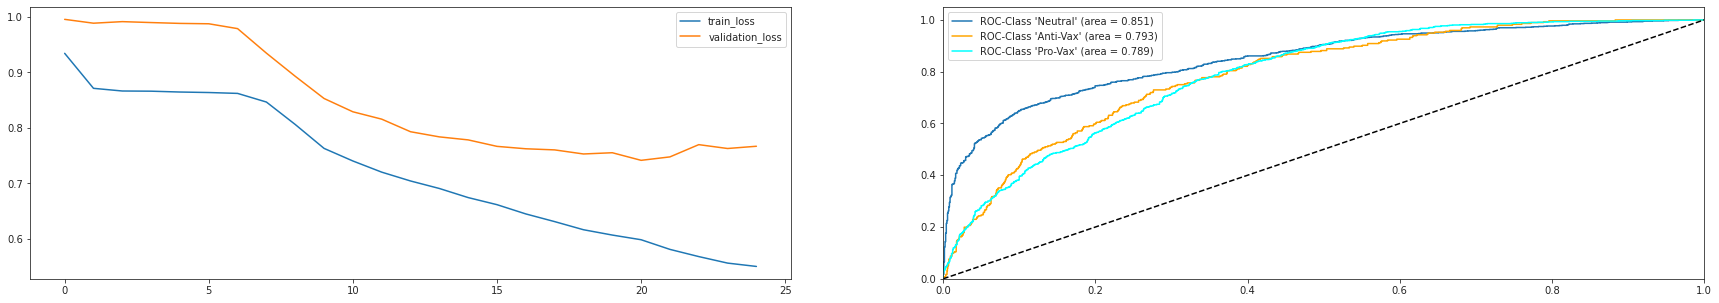

In [169]:
print("Model1 (LSTM):")
model1.eval()
print_stats(model1, X_test.to(device), y_test, history1)

### Model 2 evaluation

This is the best performing model yet. It's complex enough to comprehend the classification task, but not generalized enough to score better than any of the other best-models of our previous assignments. This is because of the label imbalance, the really low number of anti vax tweets and the general complexity an RNN model introduces. 

Some methods that we could try to cure this problem is to tune it a little differently, train it for less epochs or use a higher dropout rate. None of the above seemed to cure the problem entirely, so we can only conclude that this is the max accuracy we could get with this dataset and the provided preprocessing.

Model2 (GRU):
              precision    recall  f1-score   support

     neutral       0.76      0.74      0.75      1065
    anti-vax       0.51      0.26      0.34       296
     pro-vax       0.62      0.74      0.67       921

    accuracy                           0.68      2282
   macro avg       0.63      0.58      0.59      2282
weighted avg       0.67      0.68      0.67      2282



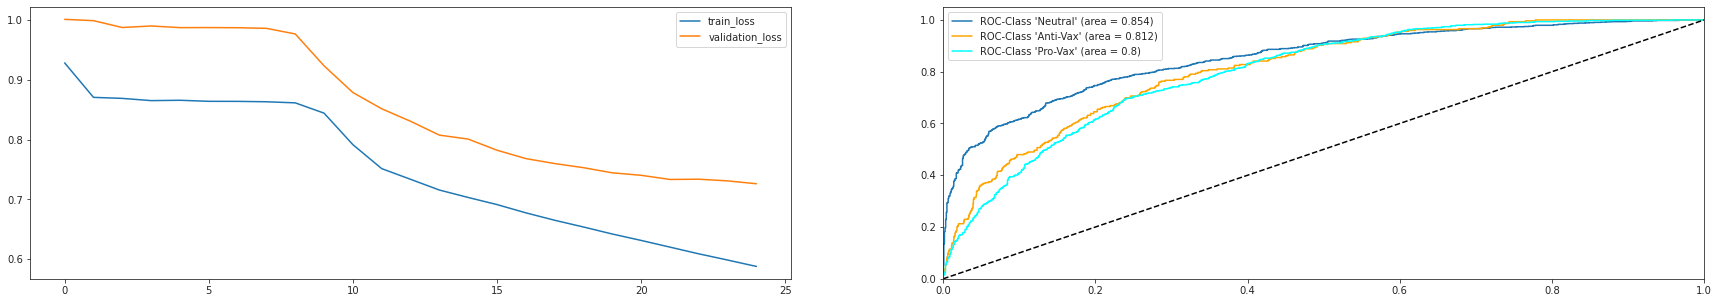

In [170]:
print("Model2 (GRU):")
model2.eval()
print_stats(model2, X_test.to(device), y_test, history2)

### Model 3 Evaluation

We can see that the introduced complexity of the skip layers, will result in a sooner overfit situation and will not improve the models statistics, but it will enchance the models predictability power, with respect to the *anti-vax* labeled tweets.

Model3 (Skip Layers):
              precision    recall  f1-score   support

     neutral       0.76      0.76      0.76      1065
    anti-vax       0.48      0.28      0.35       296
     pro-vax       0.64      0.72      0.68       921

    accuracy                           0.68      2282
   macro avg       0.63      0.59      0.60      2282
weighted avg       0.68      0.68      0.68      2282



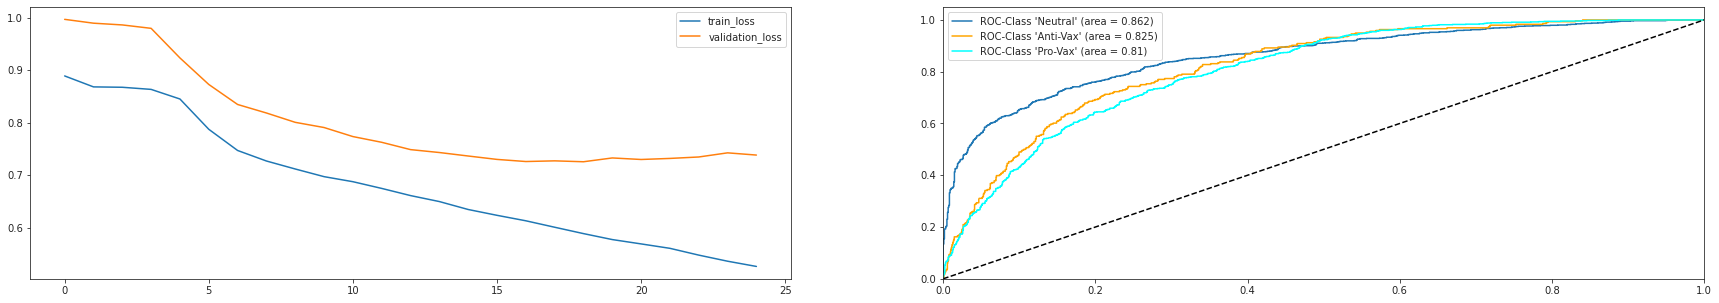

In [171]:
print("Model3 (Skip Layers):")
model3.eval()
print_stats(model3, X_test.to(device), y_test, history3)

### Model 4 Evaluation

We can clearly see that the attention mechanism cannot improve the best-model significantly since it introduces extra complexity and enchances the overfit situation. 

Among different runs, we will get similar results in fewer epochs, so we can see that attention helps us train faster, but it still cannot improve the total predicting power. 

Model4 (Model2+Attention):
              precision    recall  f1-score   support

     neutral       0.75      0.77      0.76      1065
    anti-vax       0.59      0.21      0.31       296
     pro-vax       0.62      0.73      0.67       921

    accuracy                           0.68      2282
   macro avg       0.65      0.57      0.58      2282
weighted avg       0.68      0.68      0.67      2282



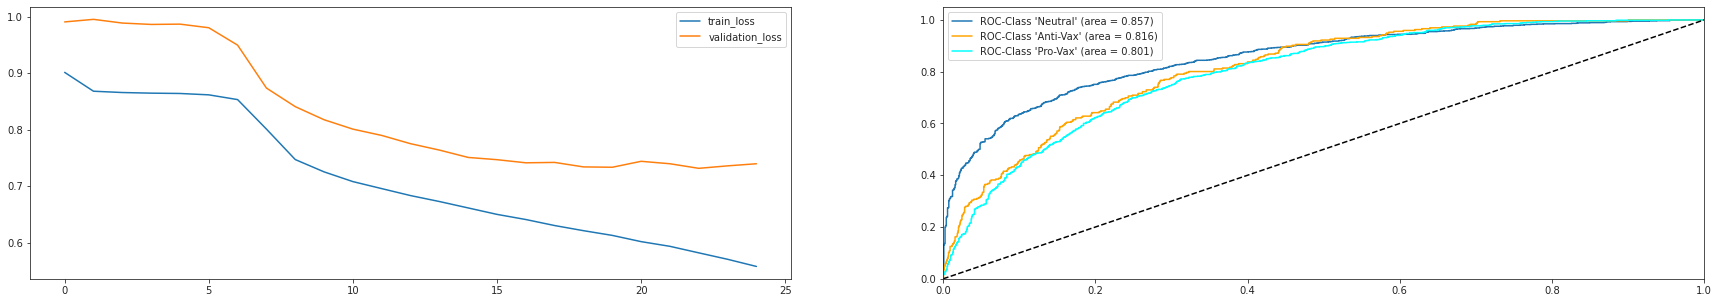

In [172]:
print("Model4 (Model2+Attention):")
model4.eval()
print_stats(model4, X_test.to(device), y_test, history4)